In [536]:
from ultralytics import YOLO
import numpy as np
import os
import polars as pl
from ultralytics import settings
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from ultralytics.utils.plotting import Annotator
import rembg

extract = YOLO("runs/detect/train6/weights/best.pt")

In [328]:
def display_image(img_array, size=512):
    img = Image.fromarray(img_array)
    # img = img.resize((size, int(img.height // (img.width / size))))
    display(img)

def extract_cars(img, conf=0.128):
    results = extract(img, conf=conf)
    img_array = np.array(img)
    for result in results:
        for box in result.boxes:
            # Extract bounding box coordinates
            left, top, right, bottom = box.xyxy[0].int().tolist()
            yield rembg.remove(img_array[top:bottom, left:right])[:, :, [0, 1, 2,]]
            
SIZE = 64
cars = []
image_paths = "all_images/"
# fill up test_images with similar images to test.
for i, image_path in enumerate(os.listdir(image_paths)[:500]):
    print(i, image_path)
    image_path = os.path.join(image_paths, image_path)
    img = Image.open(image_path)
    img_np = np.array(img)  # Convert PIL image to NumPy array
    # display_image(img_np)
    for car in extract_cars(img, conf=0.5):
        cars.append(cv2.resize(car, dsize=(SIZE, SIZE)))

cars = np.array(cars)


0: 448x640 1 car, 54.3ms
Speed: 3.1ms preprocess, 54.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 35.6ms
Speed: 2.4ms preprocess, 35.6ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 36.3ms
Speed: 2.4ms preprocess, 36.3ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 52.0ms
Speed: 2.5ms preprocess, 52.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 36.5ms
Speed: 2.5ms preprocess, 36.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 42.1ms
Speed: 2.4ms preprocess, 42.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 53.7ms
Speed: 2.5ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 1 car, 37.2ms
Speed: 2.5ms preprocess, 37.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)

0: 44

In [537]:
# with open("cars.npy", "wb+") as f:
#     np.save(f, cars)

with open("cars.npy", "rb+") as f:
    cars = np.load(f)
cars.shape

(408, 64, 64, 3)

In [538]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16 as VGG

def build_model(image_size=224, embedding_dim=128):
    # Define data augmentation layers
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomCrop(image_size, image_size),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        # tf.keras.layers.RandomBrightness(0.1),
        tf.keras.layers.RandomContrast(0.2),
    ])

    base_model = VGG(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))
    for l in base_model.layers:
        l.trainable = False
    # base_model.layers[1].trainable = True
    # base_model.layers[2].trainable = True
    # base_model.layers[3].trainable = True

    embedding_layer1 = tf.keras.Sequential([
        *base_model.layers[1: 11],  # max 20
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(embedding_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.0001), bias_regularizer=tf.keras.regularizers.l2(0.0001)),
    ])
    
    embedding_layer2 = tf.keras.Sequential([
        tf.keras.layers.Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu'),
        tf.keras.layers.Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
        tf.keras.layers.Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu'),
        tf.keras.layers.Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(embedding_dim * 4, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.1), bias_regularizer=tf.keras.regularizers.l2(0.2)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(embedding_dim, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.1), bias_regularizer=tf.keras.regularizers.l2(0.2)),
    ])

    # Build the model with inputs for two augmented images:
    input = tf.keras.layers.Input(shape=(image_size, image_size, 3))
    # augment image
    augmented_image = data_augmentation(input)
    
    # first feature extractor
    embeddings1 = embedding_layer2(augmented_image)
    
    # second feature extractor
    embeddings2 = embedding_layer2(input)

    # caluclaute the distance between the two embeddings.
    distance = tf.keras.layers.Lambda(lambda x: tf.sqrt(tf.reduce_sum(tf.square(x[0] - x[1]), axis=1)))([embeddings1, embeddings2])
    
    # Minimize the loss calculated by the lambda layer
    model = tf.keras.Model(input, distance)
    model.compile(optimizer='adam', loss='mse')
    return model

extract_model = build_model(SIZE)
extract_model.summary()
# tf.keras.utils.plot_model(extract_model, show_shapes=True, expand_nested=True, show_dtype=True)
#display_image(extract_model.layers[1](cars[0]).numpy().astype('uint8'))

Model: "model_85"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_132 (InputLayer)      [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 sequential_185 (Sequential  (None, 64, 64, 3)            0         ['input_132[0][0]']           
 )                                                                                                
                                                                                                  
 sequential_187 (Sequential  (None, 128)                  1710355   ['sequential_185[0][0]',      
 )                                                        2          'input_132[0][0]']           
                                                                                           

Epoch 1/8
17/17 [==============================] - 8s 401ms/step - loss: 65.7592 - val_loss: 32.2377
Epoch 2/8
17/17 [==============================] - 7s 389ms/step - loss: 24.2955 - val_loss: 14.6735
Epoch 3/8
17/17 [==============================] - 6s 378ms/step - loss: 11.2574 - val_loss: 7.4167
Epoch 4/8
17/17 [==============================] - 7s 394ms/step - loss: 5.8613 - val_loss: 3.9846
Epoch 5/8
17/17 [==============================] - 7s 393ms/step - loss: 3.2142 - val_loss: 2.1296
Epoch 6/8
17/17 [==============================] - 7s 389ms/step - loss: 1.7839 - val_loss: 1.1860
Epoch 7/8
17/17 [==============================] - 7s 393ms/step - loss: 1.0329 - val_loss: 0.6884
Epoch 8/8
17/17 [==============================] - 7s 441ms/step - loss: 0.5988 - val_loss: 0.4118


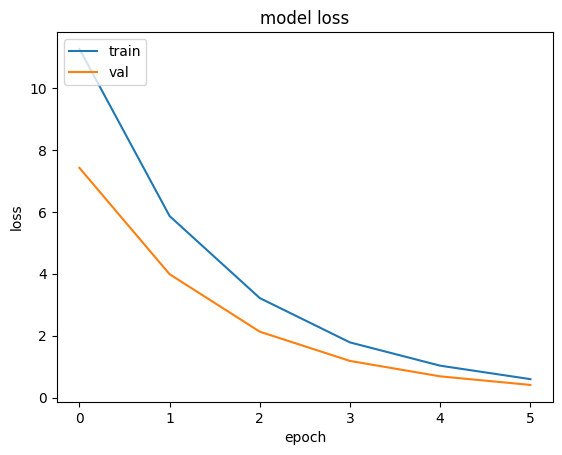

In [539]:
from sklearn.model_selection import train_test_split
zeros = np.zeros((len(cars),))

X_train, X_test, y_train, y_test = train_test_split(cars, zeros, test_size=0.2, random_state=42)

history = extract_model.fit(X_train, y_train, epochs=8, batch_size=16, validation_split=0.2)
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

100


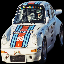

101


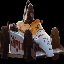

102


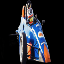

103


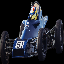

104


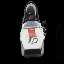

105


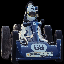

106


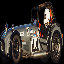

107


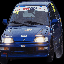

108


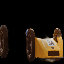

109


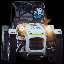

110


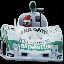

111


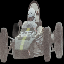

112


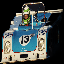

113


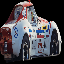

114


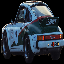

115


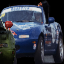

116


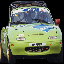

117


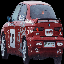

118


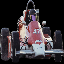

119


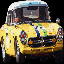

120


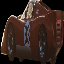

121


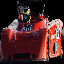

122


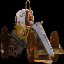

123


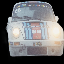

124


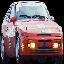

125


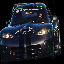

126


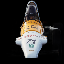

127


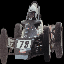

128


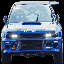

129


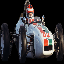

130


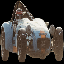

131


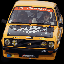

132


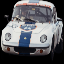

133


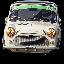

134


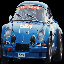

135


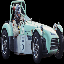

136


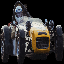

137


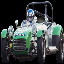

138


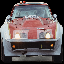

139


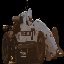

140


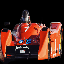

141


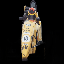

142


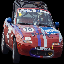

143


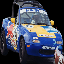

144


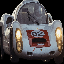

145


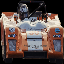

146


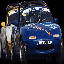

147


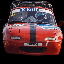

148


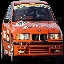

149


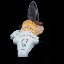

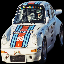

In [531]:
for i in range(50):
    print(100 + i)
    display_image(cars[100+i])
# 32 35
# 123 100
car1 = cars[125]
car2 = cars[100]
display_image(car2)

In [543]:
input_car = extract_model.layers[0](np.expand_dims(car1, axis=0))
embedding1 = extract_model.layers[2](input_car)
print(embedding1)
input_car = extract_model.layers[0](np.expand_dims(car2, axis=0))
embedding2 = extract_model.layers[2](input_car)
print(embedding2)

tf.sqrt(tf.reduce_sum(tf.square(embedding1 - embedding2), axis=1))

tf.Tensor(
[[    0.62785      0.4411     0.27159     0.46866     0.21009     0.52269     0.43235     0.41541     0.70141     0.34938     0.42937     0.64505     0.46849     0.38694     0.62443      0.6106     0.49209     0.50459     0.57808     0.56424     0.59774      0.3932      0.5135     0.44358     0.52093      0.5933
      0.44087     0.61534     0.55315     0.50921     0.49731     0.59845     0.54074     0.41397     0.60448      0.5392     0.73428     0.36407     0.44599     0.57758     0.41012     0.58077     0.47862     0.68457     0.72571     0.36944     0.67139     0.37175      0.2361     0.45999     0.70947     0.54382
       0.5203      0.2254       0.677     0.46351      0.3358     0.39561     0.37767     0.42246     0.70774     0.37557      0.5437     0.41765     0.54579     0.42237     0.63176     0.54002     0.68962     0.49567     0.72934      0.3037     0.50778      0.4281     0.59166     0.49872     0.46467      0.5577
      0.40008     0.48742     0.57797     0.476

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([   0.018348], dtype=float32)>

In [554]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def extract_features(car):
    input_car = extract_model.layers[0](np.expand_dims(car, axis=0))
    embedding = extract_model.layers[2](input_car)
    return embedding

all_features = np.vstack([extract_features(cars[i]) for i in range(100, 150, 5)])
pca = PCA(n_components=8)  # Adjust number of components as needed
pca_features = pca.fit_transform(all_features)
scaler = StandardScaler()
pca_features_normalised = scaler.fit_transform(pca_features)

In [562]:
from sklearn.cluster import DBSCAN  # Or choose a different algorithm

# Assuming you're using DBSCAN:
clustering = DBSCAN(eps=0.9, min_samples=4)  # Adjust parameters as needed
cluster_labels = clustering.fit_predict(pca_features_normalised)

-1
Images in group -1:


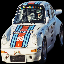

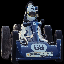

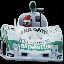

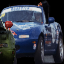

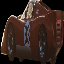

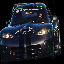

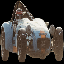

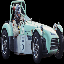

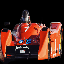

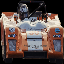

In [563]:
for label in set(cluster_labels):
    print(label)
    images_in_group = [cars[100 + i * 5] for i in range(len(cluster_labels)) if cluster_labels[i] == label]
    print(f"Images in group {label}:")
    for image in images_in_group:
        display_image(image)  # Assuming you have a display_image function